# InsCure Capstone Project 

### Import library yang akan digunakan

In [15]:
# Import Library
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sklearn
import joblib
import shutil
import random
import string
import cv2
import tempfile
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional


### Mengeload dataset dan membagi menjadi 500 gambar per kelas

In [4]:
# Initiate Directory
dataset_dir = '\Kuliah\Bangkit\Capstone\Dataset_Original'
output_dir = '\Kuliah\Bangkit\Capstone\Dataset_500'

# Image per class
num_images_per_class = 500

# Make sure there is an output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List of class
classes = os.listdir(dataset_dir)

for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        # Pilih acak 500 gambar dari kelas ini
        selected_images = random.sample(images, num_images_per_class)
        
        # Buat direktori baru untuk kelas ini di direktori tujuan
        new_class_dir = os.path.join(output_dir, cls)
        os.makedirs(new_class_dir, exist_ok=True)
        
        for img in selected_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(new_class_dir, img)
            shutil.copy(src, dst)
            
print("Dataset has been successfully partitioned.")


Dataset has been successfully partitioned.


### Mengesplit data yang telah dipartisi menjadi training set dan validation set

In [6]:
# Defining the directory
dataset_directory = '\Kuliah\Bangkit\Capstone\Dataset_500'

# Setting parameters
batch_size = 64
img_height = 294
img_width = 222
validation_split = 0.2
image_shape = (img_height, img_width, 3)

# Creating the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    validation_split=validation_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels='inferred'
)

# Creating the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    validation_split=validation_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels='inferred'
)

# Printing class names
class_names = train_dataset.class_names
print("Class names:", class_names)

Found 5000 files belonging to 10 classes.
Using 4000 files for training.
Found 5000 files belonging to 10 classes.
Using 1000 files for validation.
Class names: ['Atopic Dermatitis', 'Basal Cell Carcinoma (BCC)', 'Benign Keratosis-like Lesions (BKL)', 'Eczema', 'Melanocytic Nevi (NV)', 'Melanoma', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Warts Molluscum and other Viral Infections']


### Visualisasi Sampel Gambar


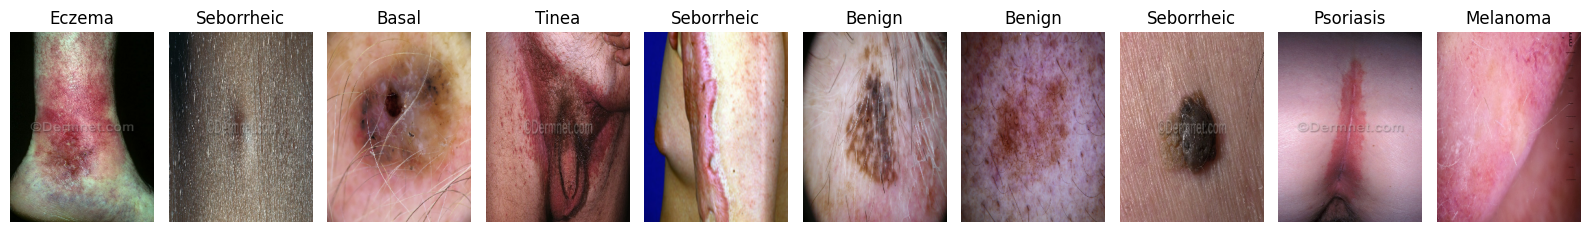

In [10]:
# Plotting a sample of 10 images from the training set
def plot_categories(train_dataset, class_names):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for images, labels in train_dataset.take(1):
    for k in range(10):
      img = images[k].numpy()
      img = array_to_img(img)
      ax = axes[k]
      label = class_names[int(labels[k])]
      simplified_label = label.split()[0]  
      ax.imshow(img, cmap="Greys_r")
      ax.set_title(simplified_label)
      ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(train_dataset, class_names)

### Membuat Training Directory dan Validation Directory


In [14]:
# Create directories to save the datasets
train_dir = 'train_dataset'
validation_dir = 'validation_dataset'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Function to copy images from dataset to directory
def copy_images(dataset, directory):
    for images, labels in dataset:
        for image, label in zip(images, labels):
            class_dir = os.path.join(directory, class_names[label.numpy()])
            os.makedirs(class_dir, exist_ok=True)
            image_path = os.path.join(class_dir, f'image_{len(os.listdir(class_dir))}.jpg')
            image_numpy = image.numpy()
            image_numpy = (image_numpy * 255).astype('uint8')  # Convert to uint8 before saving
            cv2.imwrite(image_path, cv2.cvtColor(image_numpy, cv2.COLOR_RGB2BGR))

# Copy images to training directory
copy_images(train_dataset, train_dir)

# Copy images to validation directory
copy_images(validation_dataset, validation_dir)

print("Datasets saved to directories:", train_dir, "and", validation_dir)

Datasets saved to directories: train_dataset and validation_dataset


### Membuat Generator untuk CNN dan Data Augmentation

In [17]:
# Instantiating the ImageDataGenerator class for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=90,
    fill_mode='nearest',
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Instantiating the ImageDataGenerator class for validation
validation_datagen = ImageDataGenerator(rescale=1./255)

# Passing in the appropriate arguments to the flow_from_directory method for training
train_generator = train_datagen.flow_from_directory(
    directory= 'train_dataset',
    target_size=(224, 224),  
    class_mode='categorical',  
    batch_size=32,  
    color_mode='rgb',  
    shuffle=True  
)

# Passing in the appropriate arguments to the flow_from_directory method for validation
validation_generator = validation_datagen.flow_from_directory(
    directory= 'validation_dataset',
    target_size=(224, 224),  
    class_mode='categorical',  
    batch_size=32,  
    color_mode='rgb'  
)

# Printing class names
class_names = list(train_generator.class_indices.keys())
print(f"Class: {class_names}")

Found 4000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Class: ['Atopic Dermatitis', 'Basal Cell Carcinoma (BCC)', 'Benign Keratosis-like Lesions (BKL)', 'Eczema', 'Melanocytic Nevi (NV)', 'Melanoma', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Warts Molluscum and other Viral Infections']
